## Text classification guideline

* ref: https://developers.google.com/machine-learning/guides/text-classification/step-2-5
* last updated by Wei, Feb'2021
* tensorflow version lead to Tensor error

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [2]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

In [3]:
plt.style.use('fivethirtyeight')
sns.set_context('notebook')

In [4]:
imdb = tf.keras.datasets.imdb

### 1 download the dataset

In [13]:
# due to the low download speed, i swith to use other download tool for below task

In [6]:
import pathlib
# dataset_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
# data_dir = tf.keras.utils.get_file('imdb_reviews', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)

In [7]:
data_dir = 'data/'

In [8]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('data')

In [9]:
os.listdir('data/')

['.DS_Store', 'aclImdb', 'aclImdb_v1.tar.gz']

In [10]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [11]:
%time (train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(data_path='/Users/wegzheng/Python_Projects/97_learn/data')

CPU times: user 1.61 s, sys: 2.3 s, total: 3.91 s
Wall time: 8.18 s


In [12]:
train_texts[1]

'The long list of "big" names in this flick (including the ubiquitous John Mills) didn\'t bowl me over to the extent that I couldn\'t judge the film on its actual merits. It is FULL of stereotypes, caricatures, and standard, set scenes, from the humble air-ace hero to the loud-mouthed yank flyer. The music track was such that at one point, about an hour before the end, I thought the film was over: loud, rising crescendo, grand flourish and finish then silence, but then the movie continued! I found no real storyline, haphazard writing, but smartly-pressed uniforms and the pretty Jean Simmons (pre-nose job) with a rousing little ditty. I cannot say that this picture has any of the ingredients which make a film great. I found it maudlin, mawkish and minor.'

In [13]:
train_labels[1]

0

### 2 check the data

* some important metrics to evaluate your texts
    * 1. Number of samples
    * 2. Number of classes
    * 3. Number of samples per class
    * 4. Number of words per sample
    * 5. Frequency distribution of words
    * 6. Distribution of sample length
* here we will review the training datasets for above issues.

In [14]:
len(train_texts)

25000

In [15]:
pd.DataFrame(train_labels, columns=['lable'])['lable'].value_counts()

1    12500
0    12500
Name: lable, dtype: int64

In [17]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


In [18]:
%time print("Number of words per sample median is {}".format(get_num_words_per_sample(train_texts)))

Number of words per sample median is 174.0
CPU times: user 291 ms, sys: 3.42 ms, total: 295 ms
Wall time: 293 ms


In [19]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(10,6))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

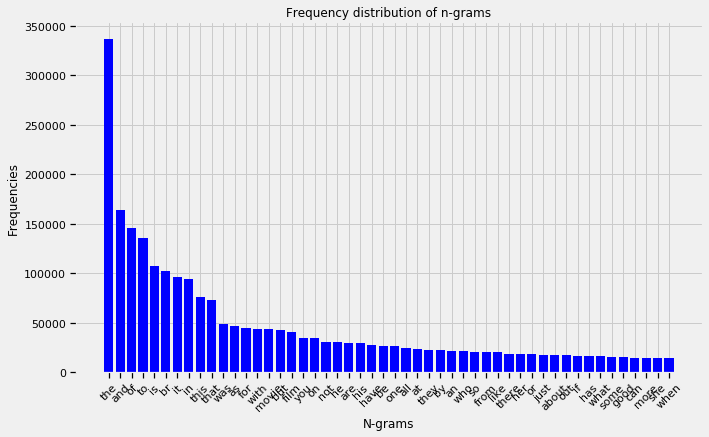

In [20]:
plot_frequency_distribution_of_ngrams(train_texts)

In [21]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

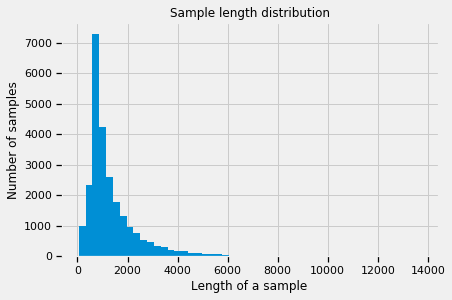

In [22]:
plot_sample_length_distribution(train_texts)

### 3 perpare the data (N-gram vectors and Sequence vectors)

* most popular methods on text analysis
    * Tokenization
    * Vectorization
        * one-hot encoding
        * count encoding
        * TF-IDF encoding
    * Feature selection
        * f_classif
        * chi2

#### 3.1 ngrame vectorization

In [23]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [16]:
%time X_train, X_val = ngram_vectorize(train_texts, train_labels, test_texts)

CPU times: user 27.9 s, sys: 773 ms, total: 28.7 s
Wall time: 28.8 s


In [37]:
X_train.shape

(25000, 20000)

#### 3.2 sequential vectorization

In [24]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [101]:
%time X_train_seq, X_test_seq, word_idx = sequence_vectorize(train_texts, test_texts)

CPU times: user 9.8 s, sys: 101 ms, total: 9.9 s
Wall time: 9.93 s


* Normaly, we should always vectoriza label data, i.e. transforming label data into [0, num_classes -1]

### 4 build, train, and evaluate the model

#### 4.1 last layer

In [25]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [26]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [27]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [28]:
def train_ngram_model(train_texts, 
                      train_labels, 
                      val_texts,
                      val_labels,
                      learning_rate=1e-3,
                      epochs=100, # originally set 1000
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """


    # Verify that validation labels are in the same range as training labels.
    num_classes = len(pd.DataFrame(train_labels, columns=['label'])['label'].unique())
    x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
    
    # Create model instance.
    model = mlp_model(layers=layers,
                        units=units,
                        dropout_rate=dropout_rate,
                        input_shape=x_train.shape[1:],
                        num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [29]:
%time X_train, X_val = ngram_vectorize(train_texts, train_labels, test_texts)

CPU times: user 27.8 s, sys: 625 ms, total: 28.5 s
Wall time: 28.5 s


In [30]:
model = mlp_model(layers=2,
                        units=64,
                        dropout_rate=0.2,
                        input_shape=X_train.shape[1:],
                        num_classes=2)


In [31]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [32]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

In [33]:
# x_tr = np.asarray(X_train)
# x_val = np.asarray(X_val)

In [35]:
history = model.fit(
            X_train,
            train_labels,
            epochs=100,
            callbacks=callbacks,
            validation_data=(X_val, test_labels),
            verbose=2,
            batch_size=128)

Epoch 1/100


TypeError: in user code:

    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:231 call
        lambda: array_ops.identity(inputs))
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/utils/control_flow_util.py:115 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/smart_cond.py:54 smart_cond
        return true_fn()
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:228 dropped_inputs
        rate=self.rate)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:538 new_func
        return func(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:5059 dropout
        return dropout_v2(x, rate, noise_shape=noise_shape, seed=seed, name=name)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:5141 dropout_v2
        x = ops.convert_to_tensor(x, name="x")
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:265 constant
        allow_broadcast=True)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:283 _constant_impl
        allow_broadcast=allow_broadcast))
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:553 make_tensor_proto
        "supported type." % (type(values), values))

    TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("DeserializeSparse:1", shape=(None,), dtype=float32), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.


In [129]:
X_train.shape[1:]

(20000,)

In [120]:
%time train_ngram_model(train_texts, train_labels, test_texts, test_labels)

Epoch 1/100


TypeError: in user code:

    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:218 call
        lambda: array_ops.identity(inputs))
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/utils/tf_utils.py:65 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/smart_cond.py:54 smart_cond
        return true_fn()
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:214 dropped_inputs
        rate=self.rate)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:4941 dropout
        return dropout_v2(x, rate, noise_shape=noise_shape, seed=seed, name=name)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:5023 dropout_v2
        x = ops.convert_to_tensor(x, name="x")
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1499 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:338 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:264 constant
        allow_broadcast=True)
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:282 _constant_impl
        allow_broadcast=allow_broadcast))
    /Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:552 make_tensor_proto
        "supported type." % (type(values), values))

    TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("DeserializeSparse:1", shape=(None,), dtype=float32), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.


In [36]:
print(tf.keras.__version__)

2.4.0
